In [1]:
#importing libraries
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#loading dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


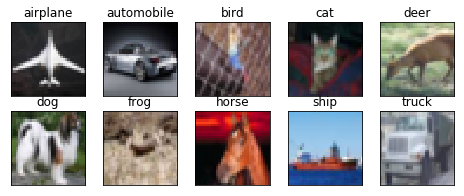

In [3]:
#class names and dummy random images
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#plot function
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#accuracy function
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#train and test features 
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_x2_output_shape(input_shape):
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])

def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)
  
def space_to_depth_x4_output_shape(input_shape):
    return (input_shape[0], input_shape[1] // 4, input_shape[2] // 4, 16 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    16 * input_shape[3])

In [9]:
# Define the model

from keras.layers import Input,SeparableConv2D,DepthwiseConv2D
from keras.layers.merge import concatenate
import keras
import tensorflow as tf
from keras.layers import Lambda


input_shape = Input(shape=(32,32,3))


# first seprable convolution
layer1 = SeparableConv2D(16,(5,5),padding='same')(input_shape)   ## 32  
layer1 = BatchNormalization()(layer1)
layer1 = Activation('relu')(layer1)
layer1 = Dropout(0.20)(layer1)

#first convolution
layer2 = Convolution2D(16,(5,5),border_mode='same')(layer1)   ##32
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)
layer2 = Dropout(0.20)(layer2)

#second convolution 
layer3 = Convolution2D(16,(5,5),border_mode='same')(layer2)  ##32
layer3 = BatchNormalization()(layer3)
layer3 = Activation('relu')(layer3)
layer3 = Dropout(0.20)(layer3)

# #skip connection merging
skip_layer_1 = concatenate([layer1,layer3])

# #second seprable convolution 

layer4 = SeparableConv2D(16,(5,5),padding='same')(skip_layer_1)  ##32
layer4 = BatchNormalization()(layer4)
layer4 = Activation('relu')(layer4)
layer4 = Dropout(0.20)(layer4)


##skip connection
skip_layer_2 = concatenate([layer4,layer1])   ##32

##maxpool
max_pool_1 = MaxPooling2D(pool_size=(2, 2))(skip_layer_2)   ##16

##third seprable convolution
layer5 = SeparableConv2D(32,(3,3),padding='same')(max_pool_1)  ##16
layer5 = BatchNormalization()(layer5)
layer5 = Activation('relu')(layer5)
layer5 = Dropout(0.20)(layer5)

# ##skip connection
space1_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_1')(layer1)

space2_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_2')(layer3)

skip_layer_3 = concatenate([space1_reshaped,space2_reshaped,layer5])   ##16

# ##third convoluiton
layer6 = Convolution2D(32,(5,5),border_mode='same')(skip_layer_3)  ##16
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)
layer6 = Dropout(0.20)(layer6)


##skip connection

space3_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_3')(layer3)

space4_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_4')(layer4)

skip_layer_4 = concatenate([space3_reshaped,space4_reshaped,max_pool_1,layer6])   ##16

##fourth seprable convolution
layer7 = SeparableConv2D(32,(3,3),padding='same')(skip_layer_4)  ##16
layer7 = BatchNormalization()(layer7)
layer7 = Activation('relu')(layer7)
layer7 = Dropout(0.20)(layer7)

##skip connections

space5_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer3)
space6_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer1)
space7_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer4)

skip_layer_5 = concatenate([space5_reshaped,space6_reshaped,space7_reshaped,layer5,layer6,layer7])   ##16

##fifth seprable conv
layer8 = SeparableConv2D(32,(3,3),padding='same')(skip_layer_5)  ##16
layer8 = BatchNormalization()(layer8)
layer8 = Activation('relu')(layer8)
layer8 = Dropout(0.20)(layer8)

##skip row 
space8_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer4)

skip_layer_6 = concatenate([space8_reshaped,layer8,layer5,layer7])   ##16
##maxpool
max_pool_2 = MaxPooling2D(pool_size=(2, 2))(skip_layer_6)     ## 8

##skip connection 

space9_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer6)

skip_layer_7 = concatenate([space9_reshaped,max_pool_2])   ##8

#fourth convolution 
layer9 = Convolution2D(64,(5,5),border_mode='same')(skip_layer_7)  ##8
layer9 = BatchNormalization()(layer9)
layer9 = Activation('relu')(layer9)
layer9 = Dropout(0.20)(layer9)

##skip connections 

space10_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer7)
space11_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer8)
space12_reshaped = Lambda(
        space_to_depth_x4,
        output_shape=space_to_depth_x4_output_shape)(layer2)

skip_layer_7 = concatenate([space10_reshaped,space11_reshaped,space12_reshaped,layer9]) 

##fifth seprable conv
layer10 = SeparableConv2D(64,(5,5),padding='same')(skip_layer_7)  ##8
layer10 = BatchNormalization()(layer10)
layer10 = Activation('relu')(layer10)
layer10 = Dropout(0.20)(layer10)

##skip connections

space13_reshaped = Lambda(
        space_to_depth_x4,
        output_shape=space_to_depth_x4_output_shape)(layer2)
space14_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer5)
space15_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer7)

skip_layer_8 = concatenate([space13_reshaped,space14_reshaped,space15_reshaped,layer10,layer9])

#fifth convolution
layer11 = Convolution2D(64,(3,3),border_mode='same')(skip_layer_8)  ##8
layer11 = BatchNormalization()(layer11)
layer11 = Activation('relu')(layer11)
layer11 = Dropout(0.20)(layer11)

#skip connection 

space16_reshaped = Lambda(
        space_to_depth_x4,
        output_shape=space_to_depth_x4_output_shape)(layer1)
space17_reshaped = Lambda(
        space_to_depth_x4,
        output_shape=space_to_depth_x4_output_shape)(layer3)
space18_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer5)
space19_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer7)
space20_reshaped = Lambda(
        space_to_depth_x4,
        output_shape=space_to_depth_x4_output_shape)(layer4)

skip_layer_9 = concatenate([space16_reshaped,space17_reshaped,space18_reshaped,space19_reshaped,space20_reshaped,layer11,layer10])

##fifth seprable conv
layer12 = SeparableConv2D(64,(5,5),padding='same')(skip_layer_9)  ##8
layer12 = BatchNormalization()(layer12)
layer12 = Activation('relu')(layer12)
layer12 = Dropout(0.20)(layer12)

##skip connections 
space22_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(layer7)
space23_reshaped = Lambda(
        space_to_depth_x4,
        output_shape=space_to_depth_x4_output_shape)(layer4)

skip_layer_8 = concatenate([space22_reshaped,space23_reshaped,layer12,layer10])

last_conv = Convolution2D(10,8)(skip_layer_8)


flat=Flatten()(last_conv)
act = Activation('softmax')(flat)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`


In [10]:
print(layer7)


Tensor("dropout_12/cond/Merge:0", shape=(?, 16, 16, 32), dtype=float32)


In [11]:
#model compilation
model = keras.models.Model(inputs=[input_shape], outputs=act)
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

W0621 09:17:10.035163 140211684308864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_4 (SeparableCo (None, 32, 32, 16)   139         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 32, 32, 16)   64          separable_conv2d_4[0][0]         
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 32, 32, 16)   0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
dropout_6 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':
W0621 09:17:11.468819 140211684308864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and wil

Epoch 1/100
390/390 [==============================] - 35s 91ms/step - loss: 5.8417 - acc: 0.3264 - val_loss: 1.5372 - val_acc: 0.4510
Epoch 2/100
390/390 [==============================] - 29s 74ms/step - loss: 1.2752 - acc: 0.5475 - val_loss: 1.4541 - val_acc: 0.4920
Epoch 3/100
390/390 [==============================] - 28s 72ms/step - loss: 1.0663 - acc: 0.6214 - val_loss: 1.0910 - val_acc: 0.6102
Epoch 4/100
390/390 [==============================] - 28s 72ms/step - loss: 0.9310 - acc: 0.6724 - val_loss: 1.4133 - val_acc: 0.5267
Epoch 5/100
390/390 [==============================] - 28s 72ms/step - loss: 0.8219 - acc: 0.7118 - val_loss: 0.9435 - val_acc: 0.6672
Epoch 6/100
390/390 [==============================] - 28s 72ms/step - loss: 0.7295 - acc: 0.7465 - val_loss: 1.4201 - val_acc: 0.5369
Epoch 7/100
390/390 [==============================] - 28s 72ms/step - loss: 0.6529 - acc: 0.7717 - val_loss: 0.9310 - val_acc: 0.6745
Epoch 8/100
390/390 [==============================] - 

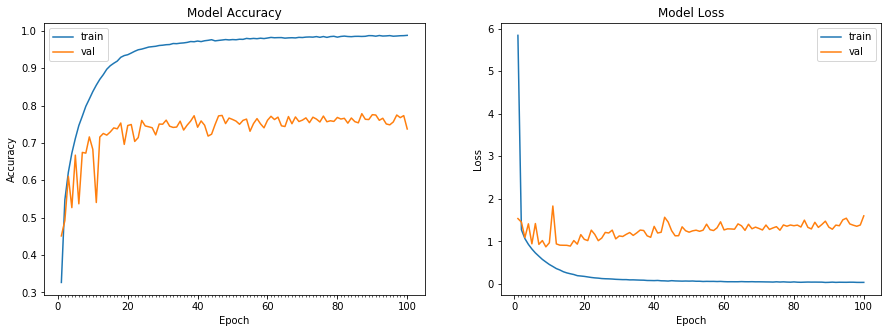

Accuracy on test data is: 73.72


In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#getting around 98.78%  training and 77.55 validation accuracy 